In [1]:
from time import time
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier
import random

In [2]:
def make_gender_mtl_data(X, y):
    y_male = y.copy()
    y_male[X['sex'] == 1] = np.nan
    y_female = y.copy()
    y_female[X['sex'] == 0] = np.nan
    return pd.concat([y_female, y_male], axis=1)


def filterClasses(X, y, classes: list):
    X = X[np.isin(y[:, 0], classes)]
    y = y[np.isin(y[:, 0], classes)]
    return X, y


def cood_encoding(x):
    x = x / 255
    indices = np.zeros((x.shape[1], x.shape[2], 2))
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            indices[i, j] = [i, j]
    indices = np.repeat(indices[np.newaxis, :, :, :], x.shape[0], axis=0)
    print(x.shape, indices.shape)
    return np.concatenate((x, indices), axis=3).reshape(x.shape[0], x.shape[1] * x.shape[2], x.shape[3] + 2)
    # return x.reshape(x.shape[0], x.shape[1] * x.shape[2], 1)

In [3]:
random_state = 2016
dataset = CIFAR10(root='nam/data/', download=True, train=True)
# X_data = dataset.data.numpy()
# y_data = dataset.targets.numpy().reshape(-1, 1)
X_data = dataset.data
y_data = np.array(dataset.targets).reshape(-1, 1)

X_data, y_data = filterClasses(X_data, y_data, [0, 1])
# y_data = np.max(1, y_data, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.2, test_size=0.8,
                                                        random_state=random_state, stratify=y_data)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=0.1, test_size=0.9, random_state=random_state,
                                            stratify=y_test)

X_train = cood_encoding(X_train)
X_test = cood_encoding(X_test)
print(X_train.shape, X_test.shape)

Files already downloaded and verified
(2000, 32, 32, 3) (2000, 32, 32, 2)
(800, 32, 32, 3) (800, 32, 32, 2)
(2000, 1024, 5) (800, 1024, 5)


In [4]:
model = NAMClassifier(
    num_epochs=40,
    num_learners=1,
    lr=0.007539419328703001,
    batch_size=64,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    device='cuda:0',
    dropout=0.03215945869651085,
    feature_dropout=0.03227589011640504,
    pos_embed=2,
)
print(X_train.shape)
print(y_train.shape)

(2000, 1024, 5)
(2000, 1)


In [5]:
s_time = time()
model.fit(X_train, y_train)
e_time = time()
pred, feature, feature_after_att, attn_output_weights = model.predict_proba(X_test)


print(sk_metrics.roc_auc_score(y_test, pred))
print("Time cost: " + str(e_time - s_time))

Format converting and model initializing are done.


2022-12-14 18:24:52.358093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/40 [00:00<?, ?it/s]

0.9000625
Time cost: 1173.473861694336


In [6]:
pred, feature, feature_after_att, attn_output_weights = model.predict_proba(X_test)
print(sk_metrics.roc_auc_score(y_test, pred))

0.9000625


In [7]:
X_test = X_test.reshape((800, 32, 32, 5))[:, :, :, 0: 3]
print(X_test.shape)
y_test = y_test.squeeze()
pred = pred.squeeze()
print(y_test.shape)
print(pred.shape)
feature = feature.detach().numpy().squeeze()

(800, 32, 32, 3)
(800,)
(800,)


In [8]:
feature = feature.reshape(800, 32, 32)

In [9]:
print(feature.shape)

(800, 32, 32)


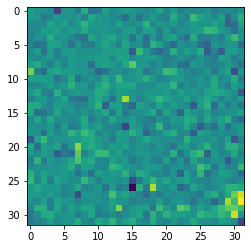

In [10]:
plt.imshow(feature[0], interpolation='nearest')
plt.show()

In [11]:
attn_output_weights = attn_output_weights.detach().numpy().squeeze()
print(attn_output_weights.shape)

(800, 1024, 1024)


In [12]:
attn_output_weights = attn_output_weights.reshape((800, 1024, 32, 32))
print(attn_output_weights.shape)

(800, 1024, 32, 32)


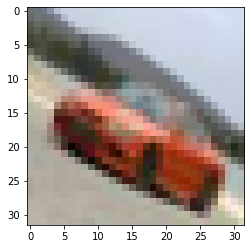

In [13]:
plt.imshow(X_test[0], interpolation='nearest')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


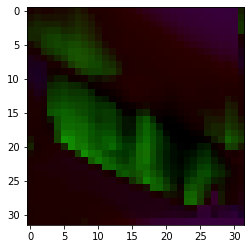

In [29]:
plt.imshow(feature_after_att[0], interpolation='nearest')
plt.show()

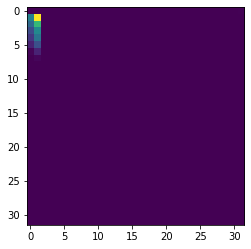

In [28]:
plt.imshow(attn_output_weights[0][0], interpolation='nearest')
plt.show()

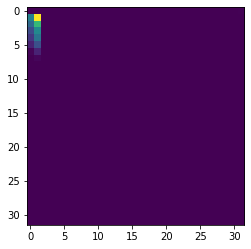

In [15]:
plt.imshow(attn_output_weights[0][0], interpolation='nearest')
plt.show()

In [16]:
feature_after_att.shape

torch.Size([800, 1024, 3])

In [17]:
feature_after_att = feature_after_att.reshape((800, 32, 32, 3))

In [18]:
feature_after_att = feature_after_att.detach().numpy()

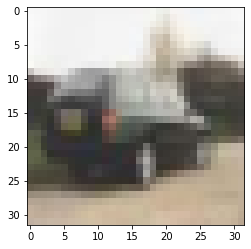

In [19]:
plt.imshow(X_test[1], interpolation='nearest')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


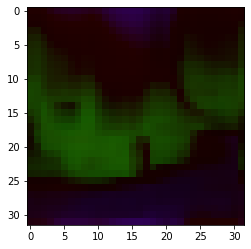

In [20]:
plt.imshow(feature_after_att[1], interpolation='nearest')
plt.show()

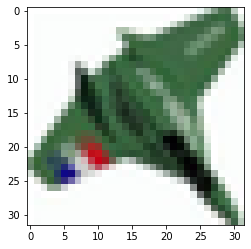

In [21]:
plt.imshow(X_test[51], interpolation='nearest')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


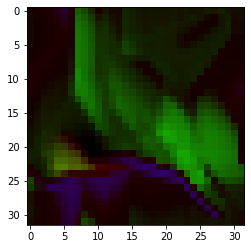

In [22]:
plt.imshow(feature_after_att[51], interpolation='nearest')
plt.show()

In [23]:
dict = {"pred": pred, "feature":feature, "feature_after_att": feature_after_att, "attn_output_weights":attn_output_weights, "X": X_test, "gt": y_test}

In [24]:
print(attn_output_weights.shape)

(800, 1024, 32, 32)


In [25]:
import csv
with open('CIFAR_data.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=dict.keys())
    writer.writeheader()
    writer.writerow(dict)

In [26]:
pred, feature, feature_after_att, attn_output_weights

(array([2.53242404e-01, 3.38074991e-02, 1.99730085e-04, 5.22260896e-13,
        9.98931017e-01, 1.67877800e-05, 2.51754873e-03, 2.19271857e-09,
        9.92185701e-01, 9.99121753e-01, 7.05208132e-06, 4.04659744e-01,
        1.94784697e-16, 1.55707346e-03, 8.08414469e-01, 3.60945437e-10,
        9.87714412e-01, 3.16725751e-08, 3.30467569e-01, 5.65426601e-06,
        7.28802875e-03, 2.27133015e-08, 1.66397159e-01, 9.99602675e-01,
        9.87243064e-01, 1.53204401e-02, 6.55199911e-06, 9.86054063e-01,
        2.57899914e-01, 9.90812685e-01, 4.58914064e-08, 1.54106871e-07,
        5.91365602e-07, 1.39012214e-01, 1.40651414e-04, 4.95229118e-10,
        8.63622179e-07, 8.68378149e-03, 5.89892381e-01, 4.76558131e-04,
        3.25374873e-11, 9.99772904e-01, 6.69156907e-15, 9.99986596e-01,
        9.99999874e-01, 2.77925624e-02, 4.79947850e-01, 8.22072370e-01,
        9.99999994e-01, 1.17686188e-03, 1.35480283e-03, 8.96460770e-05,
        7.70696570e-02, 8.79564474e-02, 3.41773993e-01, 2.607492

In [27]:
print(pred.shape)
print(feature.shape)
print(feature_after_att.shape)
print(attn_output_weights.shape)

(800,)
(800, 32, 32)
(800, 32, 32, 3)
(800, 1024, 32, 32)
